In [21]:
# Import modules

from music21 import *
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx

import dimod
import dimod.generators
from dwave.samplers import SteepestDescentSolver
from dwave.system import DWaveSampler, EmbeddingComposite

from calculators import *
from boundaryDetection import *
from graphUtilities import *
from graphPlotters import plotBoundaryStrength

In [22]:
# https://www.music21.org/music21docs/about/referenceCorpus.html#referencecorpus

beethoven = "beethoven/opus74.mxl"

score = corpus.parse("haydn/opus1no1/movement1.mxl")
excerpt = score
identifier = "haydn_opus1no1_movement1"

#excerpt.show()

In [23]:
# Boundary detection

phraseLists = []
threshold = 0.3
weightings = (0.3, 0.6)

for part in excerpt.parts:
        print(f"Creating phrases for {part.id} part...")
        #plotBoundaryStrength(part, threshold, weightings)
        phrases = extractPhrases(part, threshold, weightings, f"{part.id}")
        print(f"{len(phrases)} phrases created!")
        phraseLists.append(phrases)

pickle.dump(phraseLists, open(f"../Pickles/{identifier}_phrases.pkl", "wb"))

Creating phrases for Violin I part...
39 phrases created!
Creating phrases for Violin II part...
42 phrases created!
Creating phrases for Viola part...
31 phrases created!
Creating phrases for Cello part...
39 phrases created!


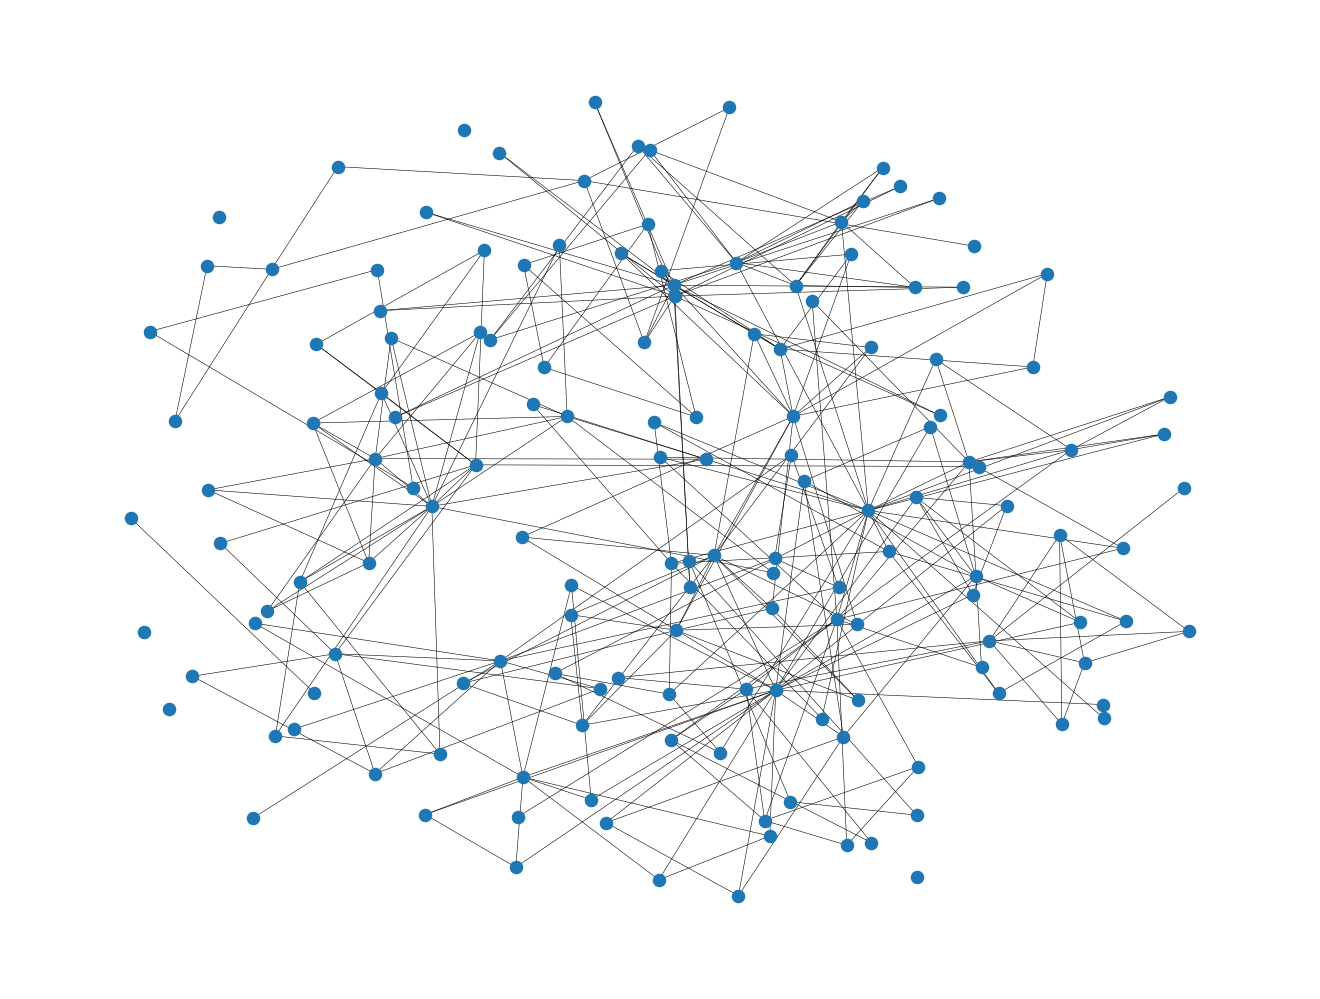

In [24]:
G = pickle.load(open(f"../Pickles/{identifier}_graph.pkl", "rb"))
pos = nx.spring_layout(G, k=0.5, seed=8)
nx.draw(G, pos=pos, node_size=15, width=0.2)

In [25]:
phraseEntropies = [(phrase.id, phrase.entropy + 1) for part in phraseLists for phrase in part]
bqm = dimod.generators.maximum_weight_independent_set(G.edges, phraseEntropies, strength_multiplier=2)
print(bqm)

BinaryQuadraticModel({'Violin I_1': -3.7024549619059113, 'Violin II_1': -3.976216224524763, 'Viola_1': -3.5, 'Cello_1': -3.5418848434970744, 'Cello_2': -1.0, 'Violin I_2': -1.0, 'Violin I_3': -3.7736843762620236, 'Violin II_3': -4.576911051568265, 'Viola_3': -3.5, 'Viola_4': -1.0, 'Cello_3': -3.377443751081734, 'Cello_4': -1.0, 'Violin I_4': -1.0, 'Violin I_5': -4.353240480262612, 'Violin II_4': -2.0, 'Violin II_5': -1.0, 'Violin II_6': -1.9182958340544896, 'Violin II_7': -1.0, 'Violin II_8': -3.7527152789797045, 'Violin II_9': -1.0, 'Violin II_10': -4.146852406035913, 'Viola_5': -4.029423942181381, 'Viola_6': -1.0, 'Viola_7': -4.267462841284266, 'Viola_8': -1.0, 'Viola_9': -2.4366664819166877, 'Cello_7': -2.0, 'Cello_8': -1.0, 'Cello_9': -3.892878689342031, 'Cello_10': -3.0, 'Cello_11': -1.0, 'Cello_12': -1.0, 'Cello_13': -3.5, 'Cello_14': -1.0, 'Cello_15': -1.9940302114769564, 'Violin I_6': -1.0, 'Violin I_7': -2.918295834054489, 'Violin I_8': -1.0, 'Violin I_9': -4.8689641616684, 'V

In [26]:
# Solve classically

dfClassical = SteepestDescentSolver().sample(bqm, num_reads=1000).to_pandas_dataframe(True)

In [ ]:
# Solve on QPU

def solveWeightedMIS(G: nx.Graph, weights: list[tuple] = [], sampler=EmbeddingComposite(DWaveSampler()), num_reads: int = 100, strength_multiplier: float = 2) -> pd.DataFrame:
    bqm = dimod.generators.maximum_weight_independent_set(G.edges, weights, strength_multiplier=strength_multiplier)
    sampler = sampler
    sampleset = sampler.sample(bqm, num_reads = num_reads)
    return sampleset.to_pandas_dataframe(True)

df = solveWeightedMIS(G, phraseEntropies, num_reads=1000)

                                              sample      energy  \
0  {'Cello_1': 0, 'Cello_10': 0, 'Cello_11': 0, '... -133.348375   
1  {'Cello_1': 1, 'Cello_10': 1, 'Cello_11': 1, '... -134.014609   
2  {'Cello_1': 1, 'Cello_10': 1, 'Cello_11': 1, '... -135.321394   
3  {'Cello_1': 1, 'Cello_10': 0, 'Cello_11': 1, '... -135.910752   
4  {'Cello_1': 0, 'Cello_10': 0, 'Cello_11': 1, '... -137.160779   

   num_occurrences  num_steps  
0                1         50  
1                1         56  
2                1         48  
3                1         51  
4                1         57  


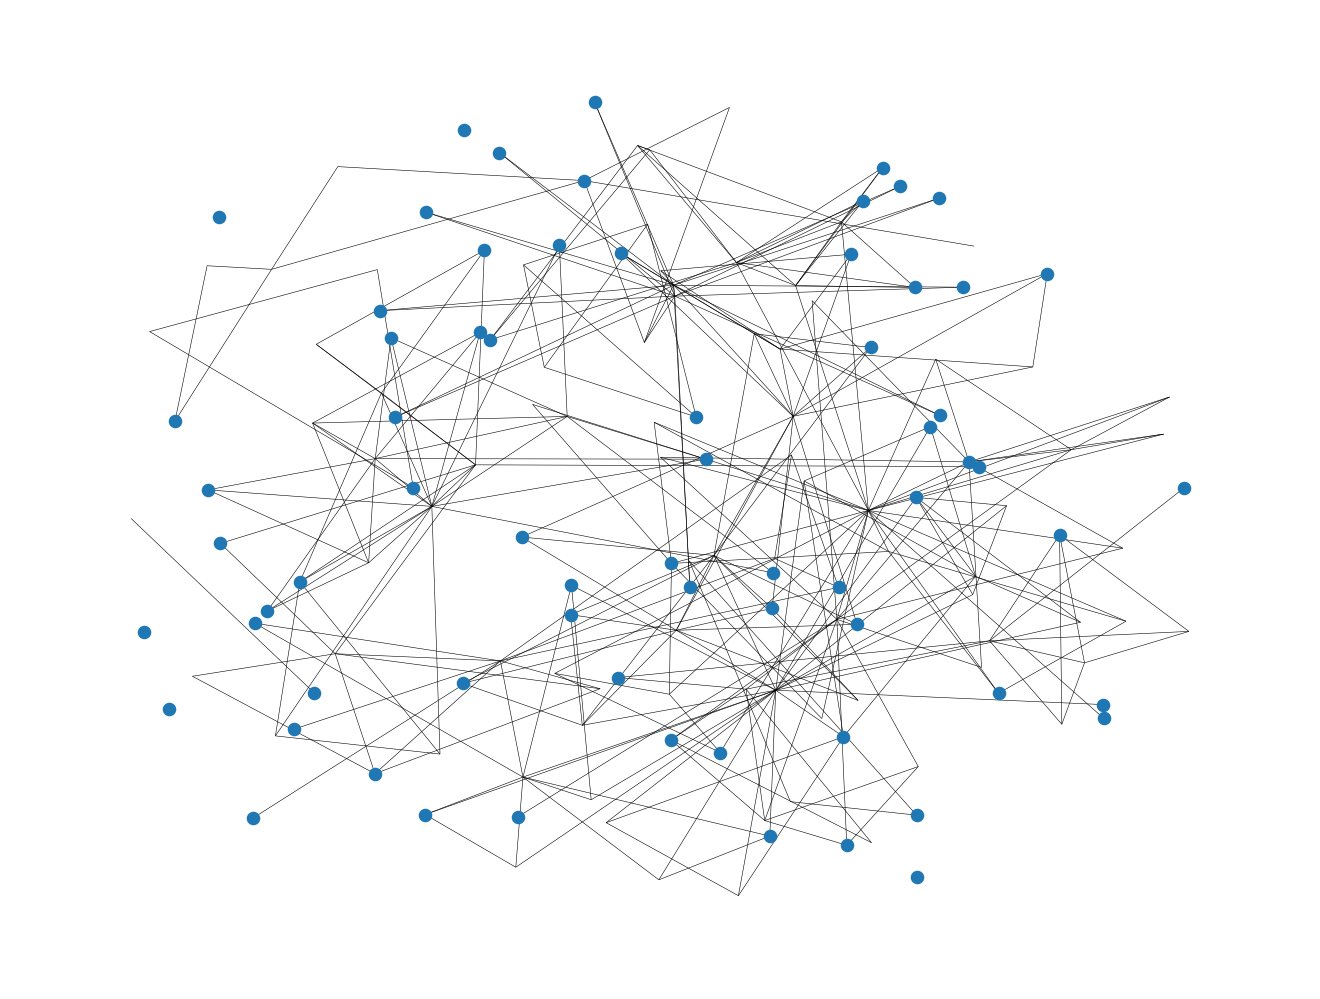

In [28]:
# Show results

print(dfClassical.head())
#print(df["energy"].sort_values(ascending=True))

sample = dfClassical["sample"][0]
chosen = [x for x in sample if sample[x] == 1]

nx.draw(G, pos=pos, node_size=15, width=0.2, nodelist=chosen)

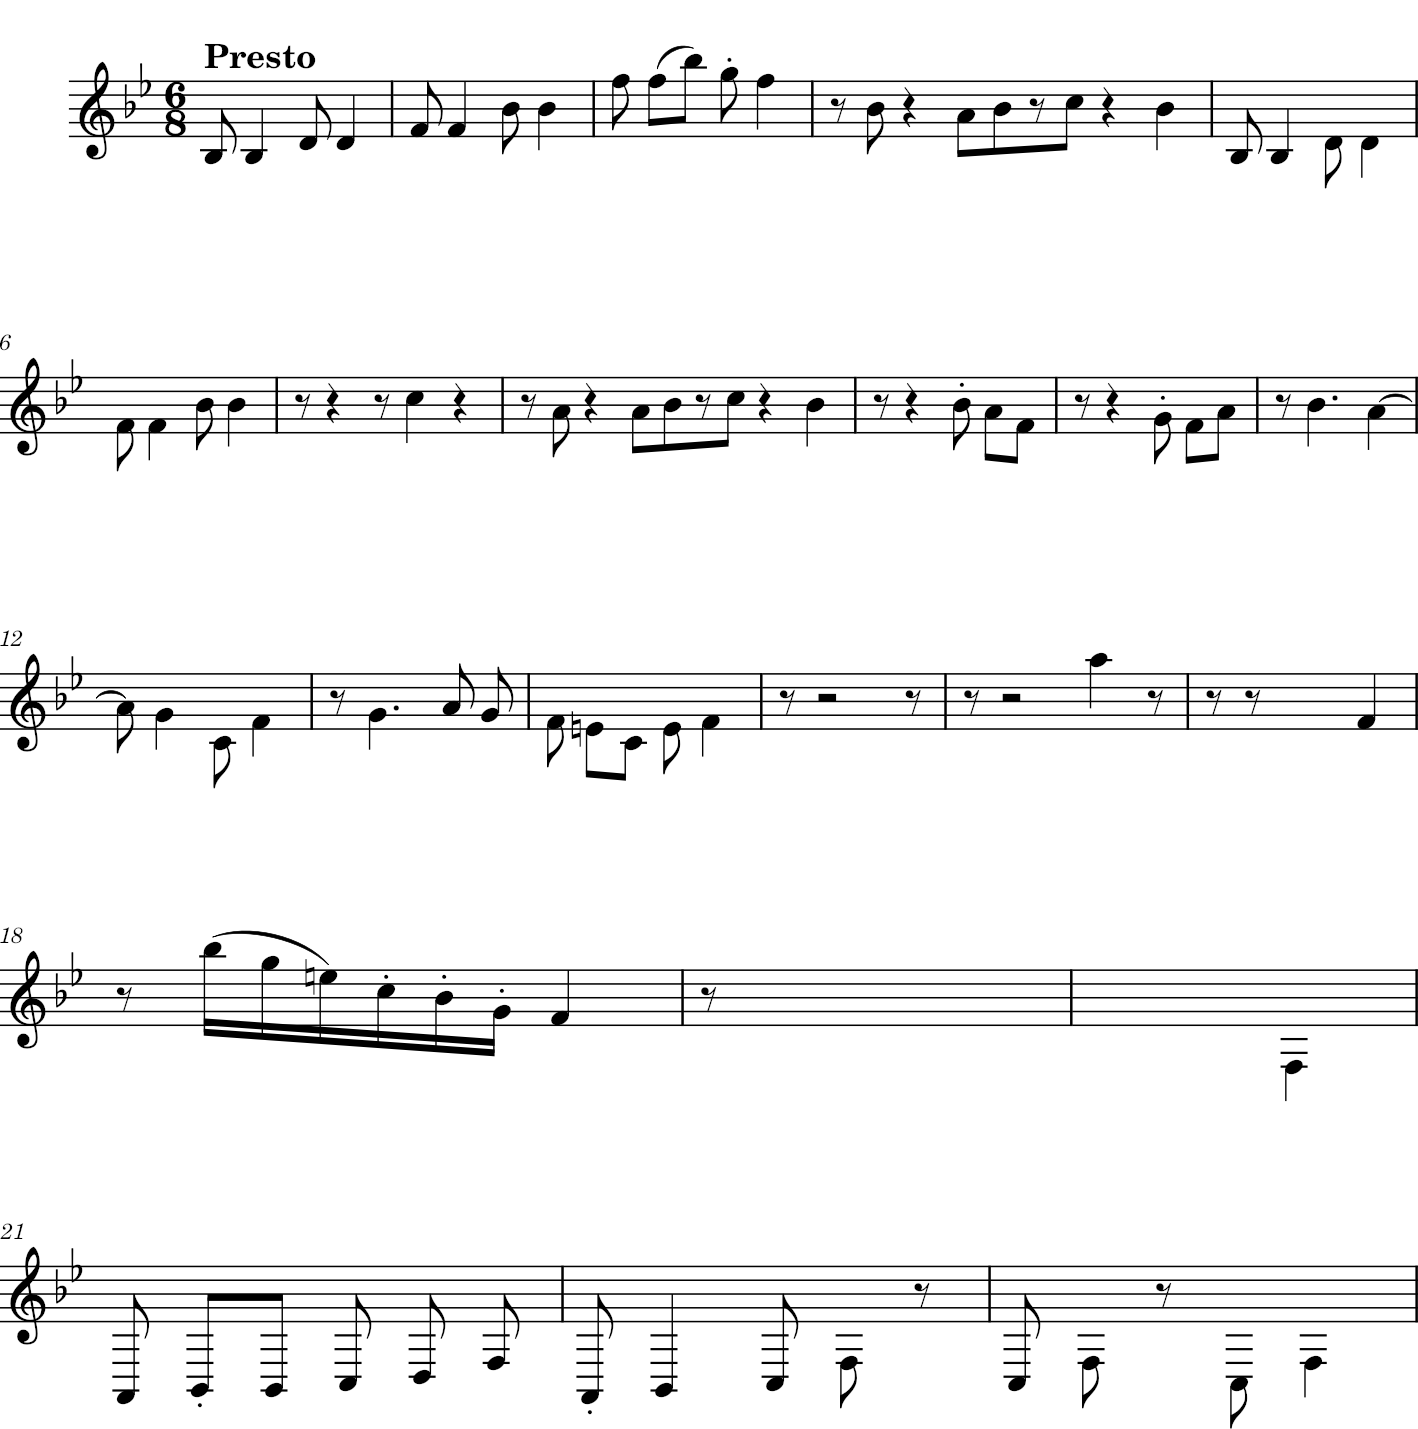

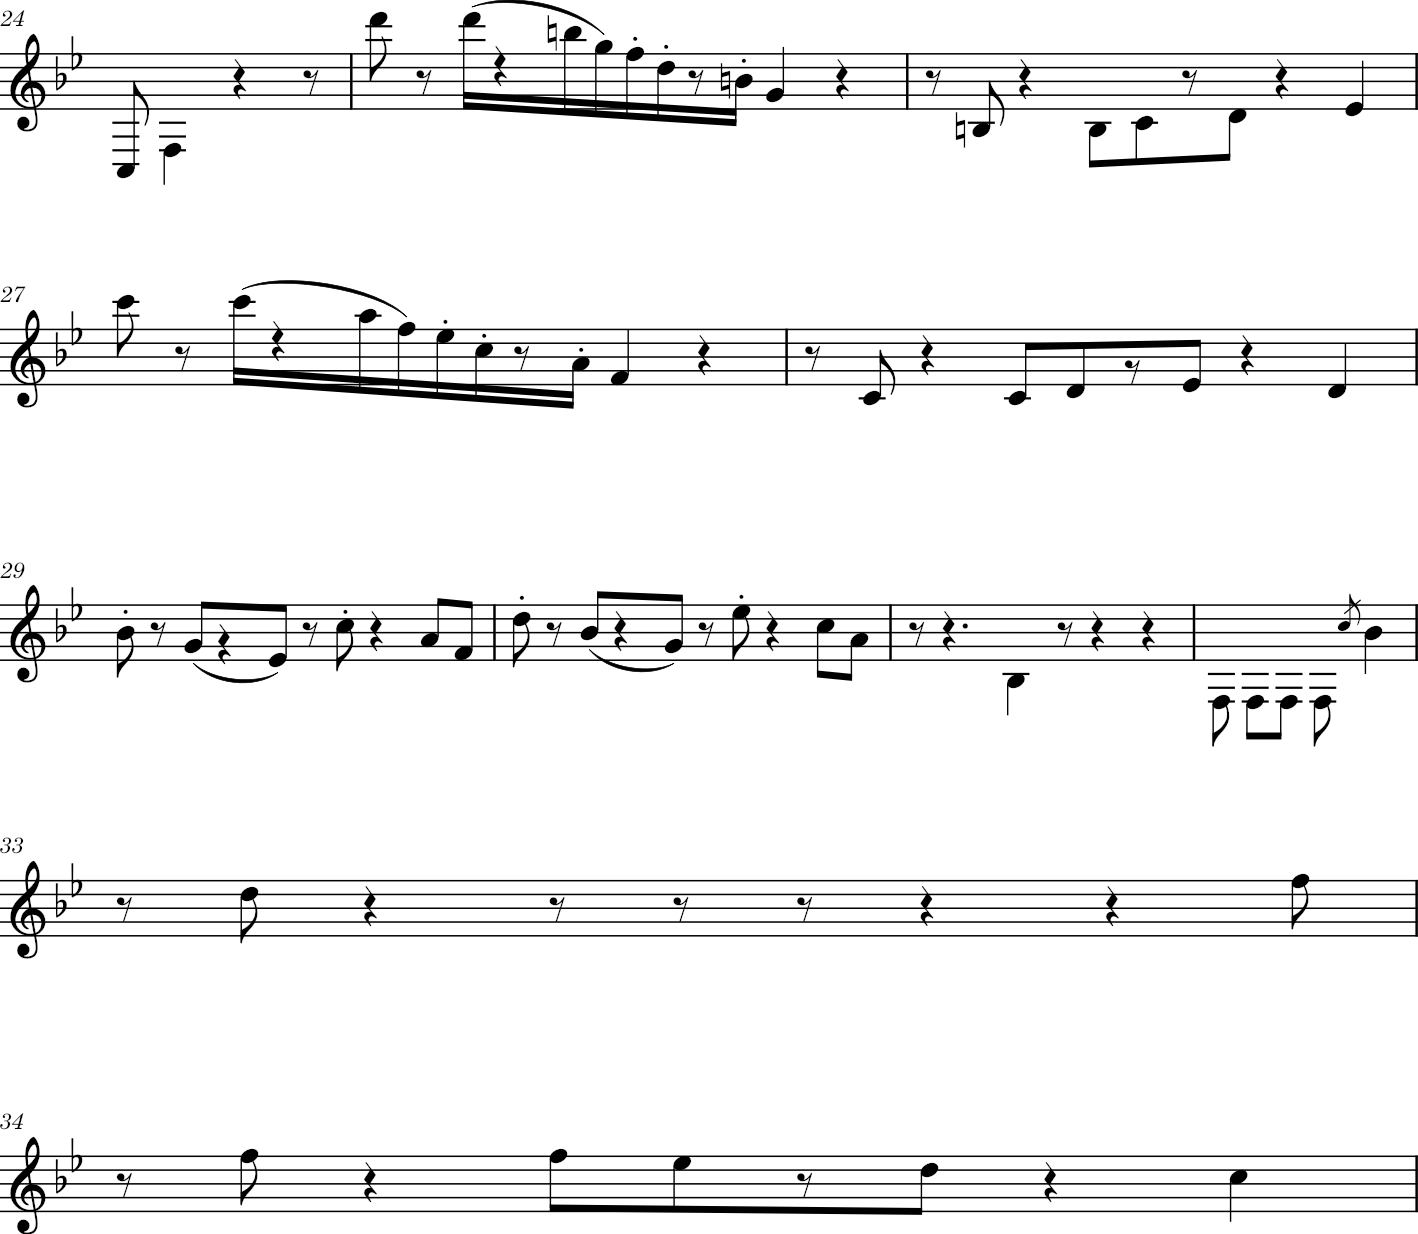

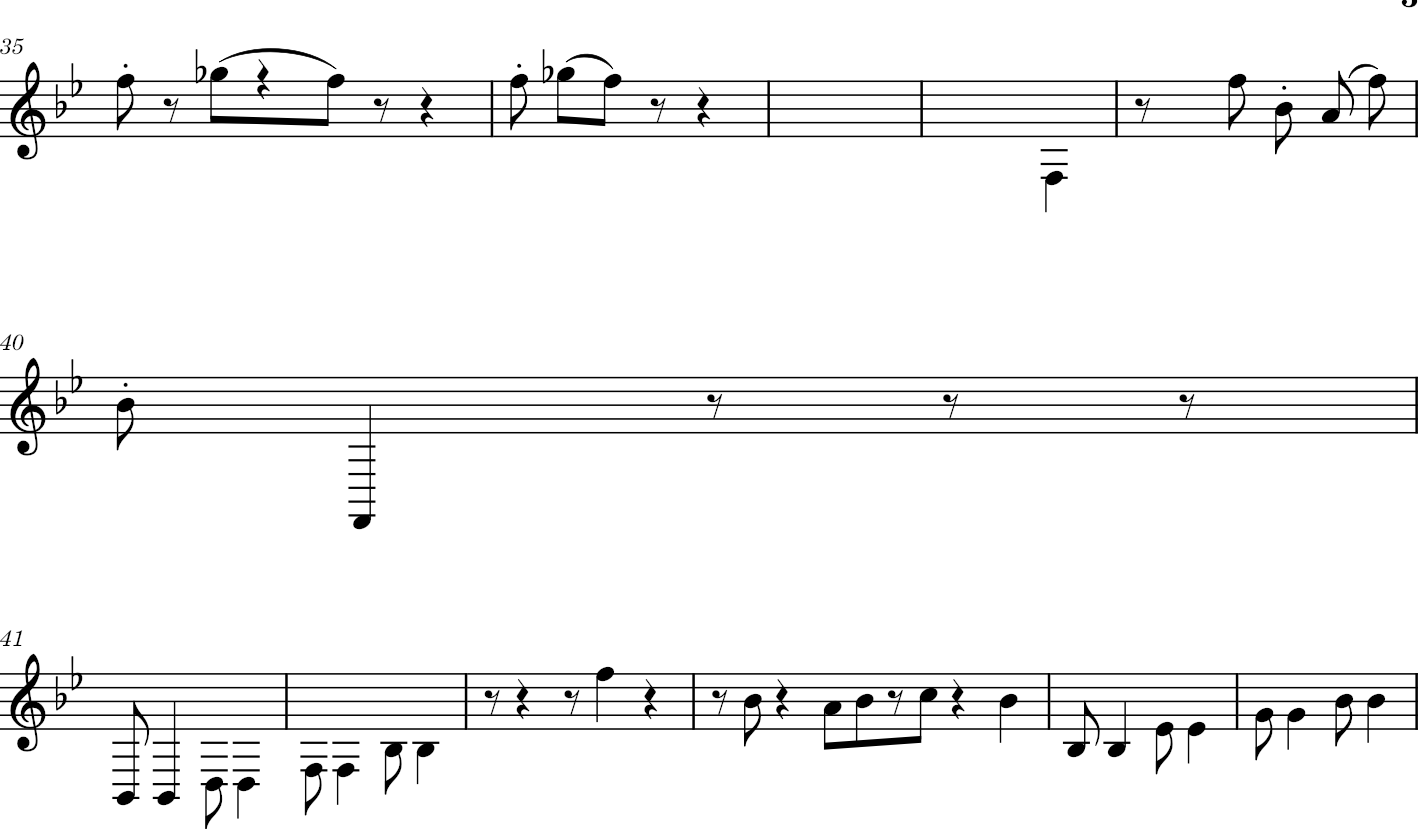

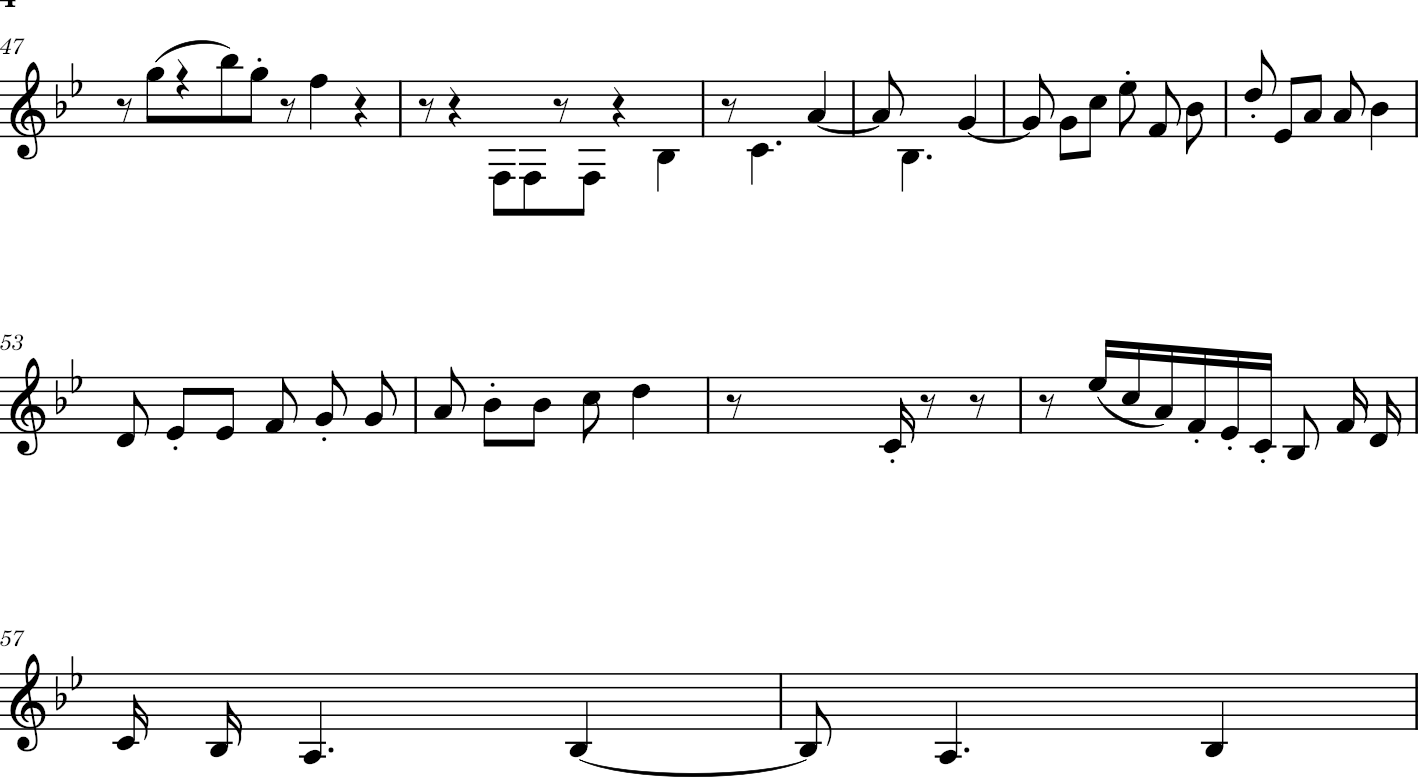

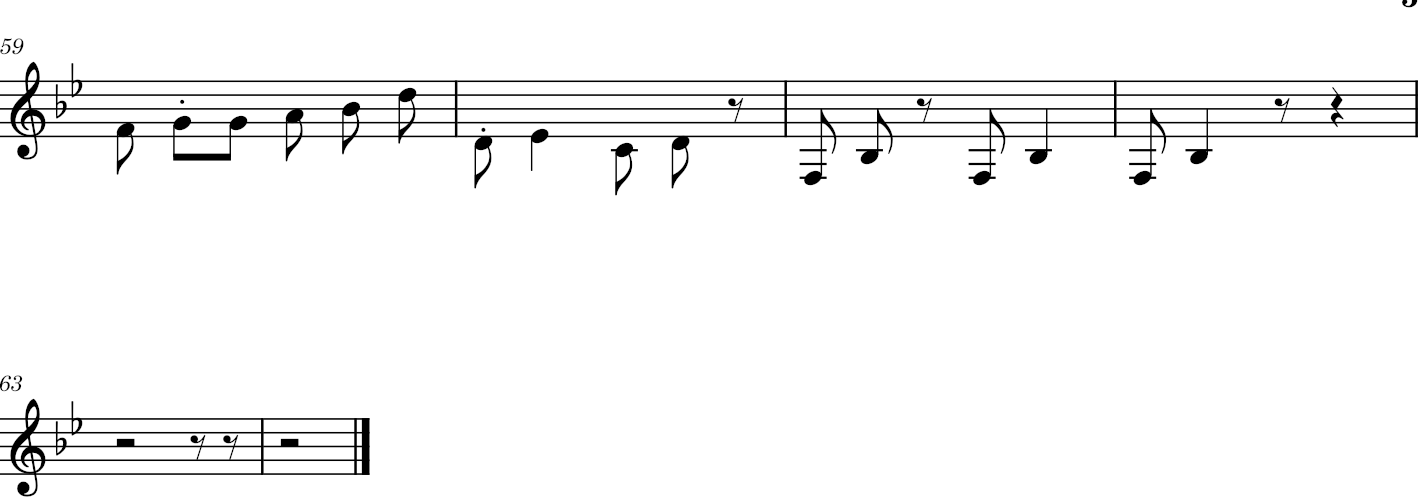

In [32]:
# Final arrangement

arrangement = stream.Stream()

for phrase in [phrase for part in phraseLists for phrase in part]:
    if phrase.id in chosen:
        arrangement.mergeElements(phrase)

excerpt.show("midi")
arrangement.show("midi")
arrangement.show()

In [38]:
# Save data

excerpt.write("xml", f"../Pickles/{identifier}_excerpt.xml")
pickle.dump(phraseLists, open(f"../Pickles/{identifier}_phraseStack.pkl", "wb"))
pickle.dump(SimpleG, open(f"../Pickles/{identifier}_simpleGraph.pkl", "wb"))
pickle.dump(ObjectG, open(f"../Pickles/{identifier}_objectGraph.pkl", "wb"))
pickle.dump(df, open(f"../Pickles/{identifier}_df.pkl", "wb"))